In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
!pwd

/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity


In [3]:
!pip3 install librosa
!pip3 install pyAudioAnalysis
!pip3 install eyed3
!pip3 install pydub

     |████████████████████████████████| 52.4MB 60kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.7-cp37-none-any.whl size=52589873 sha256=06c7321392c2a68d2c53eb87a6a10c0e2a8496d0ef57df225e53d90c7e0365bb
  Stored in directory: /root/.cache/pip/wheels/e0/da/f5/f8ab47859ae6e5f552d4fc289cc7af54879890d22bccd3d3cf
Successfully built pyAudioAnalysis
     |████████████████████████████████| 256kB 26.4MB/s 
     |████████████████████████████████| 245kB 45.5MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 5.5 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1


In [4]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate, get_audio_info

2.5.0


## Dataset

We check given directory to find all available *.wav* files.

In [5]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [6]:
#check source directory and find classes
source_dir = '/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id11139/lWGSIuUF9lE/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id11139/5w_ea9uPOKY/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id11139/zyxJy8NsKfM/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id11139/w5Jlx20UUoo/
checking dir: /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10912/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav/wav/id10912/nDpaVYtKQUo/
/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Aud

In [7]:
df = pd.DataFrame(raw)
df = df[:12000]
print(df.shape)
df.head()

(12000, 2)


,speaker,path
0,id10659,/content/drive/MyDrive/Multimodal_machine_lear...
1,id10659,/content/drive/MyDrive/Multimodal_machine_lear...
2,id10659,/content/drive/MyDrive/Multimodal_machine_lear...
3,id10659,/content/drive/MyDrive/Multimodal_machine_lear...
4,id10659,/content/drive/MyDrive/Multimodal_machine_lear...


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [8]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}', '\n')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (8399, 2), Test set size (3601, 2) 



True

In [9]:
# get sample rate and clip duration for every clip
df_train[['sr','duration']] = df_train['path'].apply(lambda p: get_audio_info(p))
df_test[['sr','duration']] = df_test['path'].apply(lambda p: get_audio_info(p))

df_train.head()

,speaker,path,sr,duration
105,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,6.240062
108,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,4.840063
142,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,6.920063
55,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,7.040063
94,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,5.280062


In [10]:
print(f'{df_train.describe()} \n {df_test.describe()}')

            sr     duration
count   8399.0  8399.000000
mean   16000.0     8.360696
std        0.0     5.752630
min    16000.0     3.960062
25%    16000.0     4.960063
50%    16000.0     6.520062
75%    16000.0     9.500063
max    16000.0    94.880062 
             sr     duration
count   3601.0  3601.000000
mean   16000.0     8.427844
std        0.0     5.943604
min    16000.0     3.960062
25%    16000.0     4.960063
50%    16000.0     6.520062
75%    16000.0     9.560063
max    16000.0    94.880062


In [11]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [12]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [13]:
df_train.head()

,speaker,path,sr,duration,mfcc,delta,zcr
105,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,6.240062,"[-196.61803, 93.85399, 1.3533596, 5.8952885, -...","[0.16142215, 0.12460785, -0.026536625, -0.0116...","[0.08516733949733038, 0.22073186612840215, 0.1..."
108,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,4.840063,"[-172.74132, 86.8228, -5.5336666, 12.343654, -...","[-0.49342048, -0.13386667, 0.33237576, 0.12552...","[0.14791806581598388, 0.2187709872397582, 0.05..."
142,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,6.920063,"[-276.1912, 78.212364, -3.6780992, 13.352934, ...","[0.7498741, -0.00033941556, -0.0905952, -0.124...","[0.1454908407703147, 0.06763738844527947, 0.08..."
55,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,7.040063,"[-263.9227, 108.15945, -10.811783, 7.7922926, ...","[-0.3663601, -0.027984047, 0.31497043, 0.06859...","[0.06579706799030359, 0.21528338912616876, 0.1..."
94,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,5.280062,"[-212.55693, 81.22508, -38.329197, 21.080471, ...","[-0.216881, 0.05254516, -0.022510586, 0.060181...","[0.15576419886101278, 0.0994305063875635, 0.11..."


In [14]:
df_test.head()

,speaker,path,sr,duration,mfcc,delta,zcr
105,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,6.240062,"[-196.61803, 93.85399, 1.3533596, 5.8952885, -...","[0.16142215, 0.12460785, -0.026536625, -0.0116...","[0.08516733949733038, 0.22073186612840215, 0.1..."
108,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,4.840063,"[-172.74132, 86.8228, -5.5336666, 12.343654, -...","[-0.49342048, -0.13386667, 0.33237576, 0.12552...","[0.14791806581598388, 0.2187709872397582, 0.05..."
142,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,6.920063,"[-276.1912, 78.212364, -3.6780992, 13.352934, ...","[0.7498741, -0.00033941556, -0.0905952, -0.124...","[0.1454908407703147, 0.06763738844527947, 0.08..."
55,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,7.040063,"[-263.9227, 108.15945, -10.811783, 7.7922926, ...","[-0.3663601, -0.027984047, 0.31497043, 0.06859...","[0.06579706799030359, 0.21528338912616876, 0.1..."
94,id10659,/content/drive/MyDrive/Multimodal_machine_lear...,16000.0,5.280062,"[-212.55693, 81.22508, -38.329197, 21.080471, ...","[-0.216881, 0.05254516, -0.022510586, 0.060181...","[0.15576419886101278, 0.0994305063875635, 0.11..."


In [15]:
# a = df_test.iloc[26,5]
# plt.plot(a)
# plt.show()
# print(a.mean())

In [16]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,4:7]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 105
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (5879, 39), Validation set size (2520, 39)


## Deep Learning Model

In [17]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4000      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [18]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 600
num_batch_size = 16


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
368/368 [==============================] - 2s 3ms/step - loss: 6.6971 - accuracy: 0.0208 - val_loss: 4.6274 - val_accuracy: 0.0218

Epoch 00001: val_loss improved from inf to 4.62743, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
368/368 [==============================] - 1s 3ms/step - loss: 4.6320 - accuracy: 0.0296 - val_loss: 4.6039 - val_accuracy: 0.0218

Epoch 00002: val_loss improved from 4.62743 to 4.60392, saving model to saved_models/speakers_classification.hdf5
Epoch 3/200
368/368 [==============================] - 1s 3ms/step - loss: 4.5996 - accuracy: 0.0299 - val_loss: 4.5844 - val_accuracy: 0.0222

Epoch 00003: val_loss improved from 4.60392 to 4.58436, saving model to saved_models/speakers_classification.hdf5
Epoch 4/200
368/368 [==============================] - 1s 4ms/step - loss: 4.5799 - accuracy: 0.0301 - val_loss: 4.5719 - val_accuracy: 0.0218

Epoch 00004: val_loss improved from 4.58436 to 4.57193, saving model to saved_models/s

### Check training history

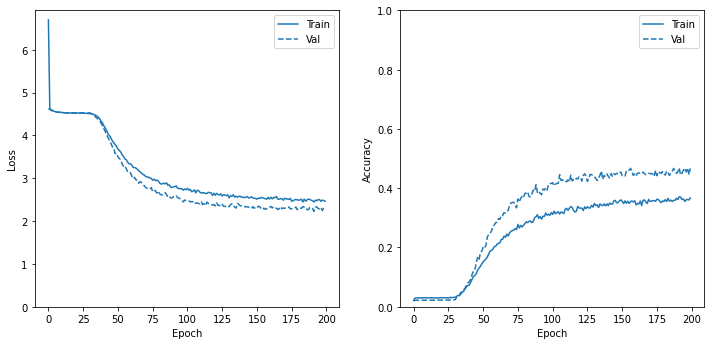

In [19]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [20]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(3601, 39)
['id10544' 'id10659' 'id10659' ... 'id10805' 'id10064' 'id10564']
              precision    recall  f1-score   support

     id10064       0.88      0.45      0.60        31
     id10065       0.75      0.65      0.70        23
     id10067       1.00      0.67      0.80        33
     id10069       0.81      0.76      0.79        17
     id10082       0.53      0.66      0.59        47
     id10083       0.82      0.67      0.74        70
     id10098       0.67      0.17      0.27        24
     id10100       0.48      0.36      0.41        28
     id10123       0.94      0.36      0.52        44
     id10124       1.00      0.33      0.50        27
     id10147       0.71      0.83      0.77        66
     id10172       1.00      0.05      0.10        19
     id10181       0.31      0.19      0.24        26
     id10183       0.51      0.73      0.60        52
     id10184       1.00      0.29      0.44        14
     id10187       0.33      0.04      0.07        25
    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Gausian Mixture Model

In [21]:
from sklearn import mixture
# fit a Gaussian Mixture Model with 16 components
# for every speaker fit a GMM and save the model
unique_speakers = df_train['speaker'].unique()
for speaker in unique_speakers:
    df_speaker = df_train[df_train['speaker'] == speaker]
    features = np.asarray(())
    for index, row in df_speaker.iterrows():
        vector = np.hstack((row['mfcc'], row['delta'], row['zcr']))
        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features,vector))
    
    gmm = mixture.GaussianMixture(n_components = 16, covariance_type='diag',n_init = 3)
    gmm.fit(features)
    
    filename = 'saved_models/gmm/' + f'gmm_{speaker}.sav'
    pickle.dump(gmm, open(filename, 'wb'))

In [22]:
# load models and predict on test
gmm_files = [os.path.join('saved_models/gmm/',fname) for fname in 
              os.listdir('saved_models/gmm/') if fname.endswith('.sav')]

#Load the Gaussian gender Models
gmm_models = [pickle.load(open(fname,'rb')) for fname in gmm_files]
unique_speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname 
              in gmm_files]

print(unique_speakers)
nr_errors = 0
total_samples = len(df_test)
for index, row in df_test.iterrows():
    log_likelihood = np.zeros(len(gmm_models)) 
    features = np.hstack((row['mfcc'], row['delta'], row['zcr']))
    features = features.reshape(1,-1)
    
    for i, gmm in enumerate(gmm_models):
        scores = np.array(gmm.score(features))
        log_likelihood[i] = scores.sum()

    y_pred = np.argmax(log_likelihood)
    if unique_speakers[y_pred] != 'gmm_' + row['speaker']+ '.sav':
        nr_errors += 1

accuracy = ((total_samples - nr_errors) / total_samples) * 100
print (f'The Accuracy with (MFCC + DELTA + ZCR) and GMM is : {accuracy}')


['gmm_id10659.sav', 'gmm_id10564.sav', 'gmm_id10083.sav', 'gmm_id10618.sav', 'gmm_id10261.sav', 'gmm_id10548.sav', 'gmm_id10390.sav', 'gmm_id10069.sav', 'gmm_id10769.sav', 'gmm_id10187.sav', 'gmm_id10718.sav', 'gmm_id10082.sav', 'gmm_id10529.sav', 'gmm_id10184.sav', 'gmm_id10478.sav', 'gmm_id10617.sav', 'gmm_id10734.sav', 'gmm_id10547.sav', 'gmm_id10100.sav', 'gmm_id10706.sav', 'gmm_id10686.sav', 'gmm_id10437.sav', 'gmm_id10757.sav', 'gmm_id10181.sav', 'gmm_id10768.sav', 'gmm_id10355.sav', 'gmm_id10237.sav', 'gmm_id10717.sav', 'gmm_id10657.sav', 'gmm_id10562.sav', 'gmm_id10436.sav', 'gmm_id10417.sav', 'gmm_id10067.sav', 'gmm_id10491.sav', 'gmm_id10236.sav', 'gmm_id10705.sav', 'gmm_id10781.sav', 'gmm_id10475.sav', 'gmm_id10733.sav', 'gmm_id10098.sav', 'gmm_id10544.sav', 'gmm_id10435.sav', 'gmm_id10590.sav', 'gmm_id10124.sav', 'gmm_id10716.sav', 'gmm_id10183.sav', 'gmm_id10235.sav', 'gmm_id10467.sav', 'gmm_id10354.sav', 'gmm_id10767.sav', 'gmm_id10489.sav', 'gmm_id10704.sav', 'gmm_id1063